In [76]:
import torch


print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cu121
Is CUDA available: True


## Dataset Setup and EDA

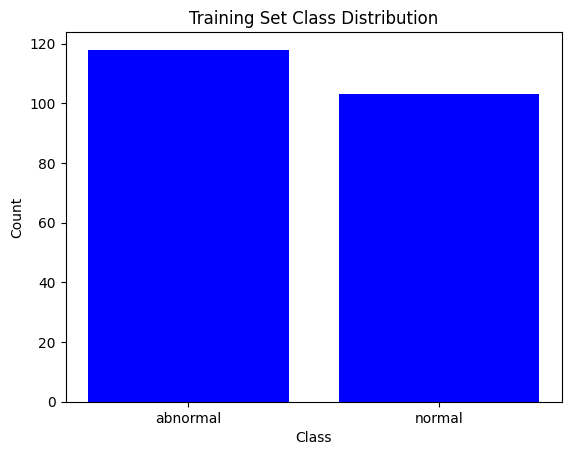

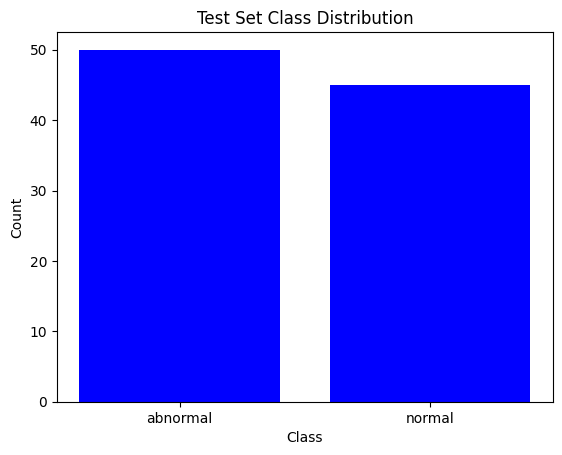

In [77]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def count_images(data_dir):
    """
    Recursively count the images in each class subfolder.
    """
    class_counts = Counter()
    for root, dirs, files in os.walk(data_dir):
        # If there are no further subdirectories, root should be a class folder
        if len(dirs) == 0:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

train_dir = 'C:\\Users\\Moh\\Desktop\\GPTest1\\PanoramicX\\trainX'
 
test_dir  = 'C:\\Users\\Moh\\Desktop\\GPTest1\\PanoramicX\\TestX'

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

# Plot the distribution for train set
plt.bar(train_counts.keys(), train_counts.values(), color='blue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the distribution for test set
plt.bar(test_counts.keys(), test_counts.values(), color='blue')
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


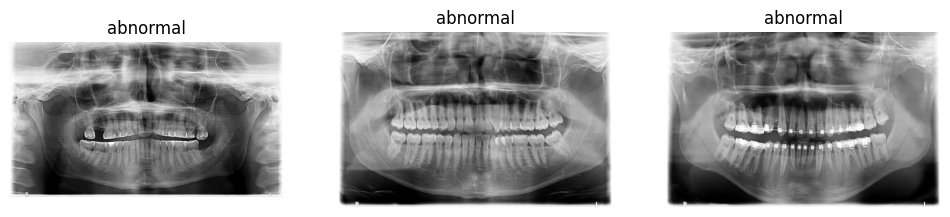

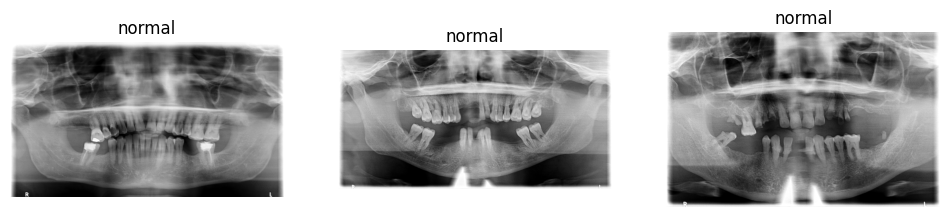

In [78]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_sample_images(data_dir, n_samples=3):
    """
    Display a few random images from each class folder in grayscale.
    """
    classes = [
        cls for cls in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, cls))
    ]
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        try:
            samples = random.sample(os.listdir(cls_path), n_samples)
        except ValueError:
            samples = os.listdir(cls_path)
        plt.figure(figsize=(12, 4))
        for i, sample in enumerate(samples):
            img_path = os.path.join(cls_path, sample)
            img = Image.open(img_path)
            plt.subplot(1, n_samples, i + 1)
            # Display in grayscale by specifying 'cmap=gray'
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
        plt.show()

# Call the function to display sample images from the training set
show_sample_images(train_dir, n_samples=3)


##  Data Preprocessing
 

In [79]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset


# Mild augmentations for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# No augmentations for validation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



dataset = datasets.ImageFolder(root='C:/Users/Moh/Desktop/GPTest1/PanoramicX/trainX')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_indices, val_indices = random_split(range(len(dataset)), [train_size, val_size])


train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataset.dataset = datasets.ImageFolder(root='C:/Users/Moh/Desktop/GPTest1/PanoramicX/trainX', transform=train_transforms)
val_dataset.dataset = datasets.ImageFolder(root='C:/Users/Moh/Desktop/GPTest1/PanoramicX/trainX', transform=val_transforms)

test_dataset = datasets.ImageFolder(root='C:/Users/Moh/Desktop/GPTest1/PanoramicX/TestX', transform=val_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)






## Define The EfficientNet model 

In [80]:
import torchvision.models as models

import torch.nn as nn
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 2  # e.g., 'normal' vs 'abnormal'

# Load a pretrained EfficientNet-B0
model = models.efficientnet_b2(pretrained=True)

# EfficientNet-B0’s final classifier is model.classifier,
# which is typically something like:
# Sequential(
#   (0): Dropout(p=0.2, inplace=True)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
# )
# We'll replace the final layer with a new Linear for 2 classes:

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)
print(model)


c:\Users\Moh\Desktop\GPTest1\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Moh\Desktop\GPTest1\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\Moh/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 23.8MB/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Train The Model 

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001 , weight_decay=1e-4 )

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_correct += predicted.eq(labels).sum().item()
            train_total += labels.size(0)
        
        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {100.*train_correct/train_total:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {100.*val_correct/val_total:.2f}%")

# Call it
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)


Epoch 1/15
Train Loss: 0.7099, Train Accuracy: 55.68%
Val Loss: 0.7452, Val Accuracy: 42.22%
Epoch 2/15
Train Loss: 0.6741, Train Accuracy: 57.39%
Val Loss: 0.7040, Val Accuracy: 60.00%
Epoch 3/15
Train Loss: 0.6266, Train Accuracy: 67.05%
Val Loss: 0.6842, Val Accuracy: 55.56%
Epoch 4/15
Train Loss: 0.5996, Train Accuracy: 69.32%
Val Loss: 0.6642, Val Accuracy: 62.22%
Epoch 5/15
Train Loss: 0.5566, Train Accuracy: 79.55%
Val Loss: 0.6485, Val Accuracy: 62.22%
Epoch 6/15
Train Loss: 0.5381, Train Accuracy: 76.14%
Val Loss: 0.6662, Val Accuracy: 66.67%
Epoch 7/15
Train Loss: 0.5103, Train Accuracy: 75.57%
Val Loss: 0.6770, Val Accuracy: 62.22%
Epoch 8/15
Train Loss: 0.4497, Train Accuracy: 84.09%
Val Loss: 0.6592, Val Accuracy: 66.67%
Epoch 9/15
Train Loss: 0.3999, Train Accuracy: 87.50%
Val Loss: 0.6421, Val Accuracy: 68.89%
Epoch 10/15
Train Loss: 0.4077, Train Accuracy: 82.95%
Val Loss: 0.6489, Val Accuracy: 66.67%
Epoch 11/15
Train Loss: 0.3271, Train Accuracy: 89.20%
Val Loss: 0.66

## Evaluate the Model 

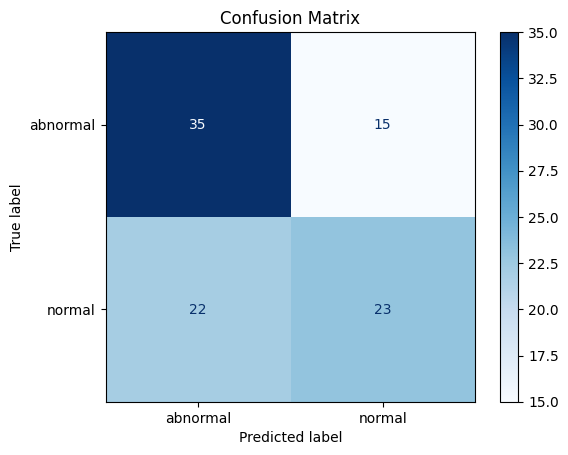

Performance Metrics:
Accuracy: 0.6105
Precision: 0.6099
Recall: 0.6105
F1 Score: 0.6068


In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Print metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate
class_names = train_dataset.dataset.classes  # or val_dataset.dataset.classes
evaluate_model(model, test_loader, class_names)
